In [1]:
using ReactiveMP, Rocket, GraphPPL
using KernelFunctions, LinearAlgebra, Random, Plots
using Distributions 

## Regression model
Consider the following model:
\begin{align}
y_i &= f(x_i) \\
t_i &= y_i + \epsilon_i, \quad \quad \epsilon_i \sim \mathcal{N}(0, \sigma^2)
\end{align}
where $x_i$ represents the input, $y_i$ the function value evaluated at $x_i$, and $t_i$ the noisy observation of $y_i$. 
The noise variance $\sigma$ is known. All variables are 1-D. 

The function $f(x)$ is unknown and our goal is to find $f(x)$ by Gaussian Process (GP).  

## 1) Create meta

In [2]:
"""
We create a "meta" structure to store the information of the GP. This structure includes
x::X : the pseudo input points  
θ::T : the hyperparameters of kernels, including "magnitude scale" θ[1] and "length-scale" θ[2]
kernel::K : the kernel of GP. 

Note that in this notebook, we assume GP is zero-mean, so we don't store the mean function inside the "meta" structure 
"""
mutable struct GPMeta{X,T,K}
    x::X
    θ::T
    kernel::K 
end
## Note that here I assume the GP is zero-mean, so we only need to define kernel
get_x(meta::GPMeta) = meta.x # this is a collection of inducing points x = [x_1, x_2, ..., x_m]
get_params(meta::GPMeta) = meta.θ  # θ stores magnitude scale θ[1] and length-scale θ[2] 
get_kernel(meta::GPMeta) = meta.kernel


get_kernel (generic function with 1 method)

## 2) Create GPPrior node

In [3]:
struct GPPrior end

@node GPPrior Stochastic [out]

### Rules for GPPrior node 

In [4]:
@rule GPPrior(:out, Marginalisation) (meta::GPMeta, ) = begin 
    x = get_x(meta) #get inducing points
    θ = get_params(meta) #get hyperparameters
    k = get_kernel(meta) # this is the kernel without any additional parameters from users
    kernel = θ[1] * with_lengthscale(k, θ[2]) #add parameters to the kernel

    K_xx = kernelmatrix(kernel, x) # compute the covariance matrix from x 
    
    return MvNormalMeanCovariance(zeros(length(x)),K_xx)
end

## 3) Create GPPrediction Node

In [5]:
struct GPPrediction end

@node GPPrediction Stochastic [out, in, f]

### Rules for GPPrediction node

In [6]:
## forward message toward "out" 
@rule GPPrediction(:out, Marginalisation) (q_in::PointMass, q_f::MultivariateNormalDistributionsFamily, meta::GPMeta,) = begin
    x_i = mean(q_in) # get input x_i
    k = get_kernel(meta) # get kernel
    θ = get_params(meta) # get hyperparameters

    kernel = θ[1] * with_lengthscale(k, θ[2]) # kernel with user hyperparameters
    
    #compute k_xx
    k_xx = kernelmatrix(kernel,[x_i])[] 

    return NormalMeanVariance(0, k_xx)
end


## backward message toward "f"
@rule GPPrediction(:f, Marginalisation) (m_out::UnivariateNormalDistributionsFamily, q_in::PointMass, meta::GPMeta,) = begin
    x_i = mean(q_in)
    mean_out, var_out = mean_cov(m_out)

    k = get_kernel(meta)
    X = get_x(meta) # X from meta
    θ = get_params(meta)

    kernel = θ[1] * with_lengthscale(k, θ[2]) # kernel with user hyperparameters

    K_xx = kernelmatrix(kernel, X) #+ 1e-9*diageye(length(X))#covariance matrix from meta 
    if typeof(x_i) <: Vector
        K_x = kernelmatrix(kernel, X, x_i) # k_xi the cross-covariance matrix k(X,x_i) between X from meta and x_i 
    else
        K_x = kernelmatrix(kernel, X, [x_i]) # in this case, x_i is scalar, so we convert it to vector
    end

    α  = inv(K_xx) * K_x
    A = α * α' + 1e-9*diageye(length(α))

    σ_p² = kernelmatrix(kernel, [x_i]) - K_x' * inv(K_xx) * K_x # predictive variance inside the GPPrediction node   

    # compute the mean and the covariance of the backward message toward "f"
    m = inv(A) * mean_out * α  
    Σ = (var_out + σ_p²[]) .* inv(A) # the covariance matrix of the backward message toward "in" 

    return MvNormalMeanCovariance(vec(m), Σ)
end 

## Model

In [7]:
@model function gp_regress(input, X, kernel, θ, n, σ²)
    f ~ GPPrior() where {meta = GPMeta(X, θ, kernel)}

    y = randomvar(n)
    t = datavar(Float64,n)

    for i=1:n
        y[i] ~ GPPrediction(input[i],f) where {meta = GPMeta(X, θ, kernel)}
        t[i] ~ NormalMeanVariance(y[i],σ²)
    end

    return f, y, t
end

## Inference

In [8]:
function inference(input, output, X, kernel, θ, σ²)
    n = length(output)
    model, (f,y,t) = gp_regress(model_options(limit_stack_depth=100), input, X, kernel, θ, n, σ²)

    marginal_f = keep(Marginal)
    subscription = subscribe!(getmarginal(f), marginal_f)

    update!(t, output)
    unsubscribe!(subscription)
    return marginal_f
end

inference (generic function with 1 method)

## Generate data

In [9]:
Random.seed!(14)
x_input = range(0, 5, length=100); #input
f_true = 2*sin.(x_input) .+ cos.(2*x_input); # true process

#pos = sort(randperm(length(x_input))[20:5:100]); # position where we observe data
pos = collect(10:5:100)
@show length(pos)
x_obser = x_input[pos]; # x-positions of observed point

σ² = 0.2
y_obser = f_true[pos] + σ²*randn(length(x_obser)); # noisy observation
#for meta information
X = collect(x_input)
θ = [1., .153]; # θ = [σ², length-scale]

length(pos) = 19


In [10]:
f_estimate = inference(x_obser, y_obser, X, SEKernel(), θ, σ²);

In [11]:
meanfunc, covmatrix = mean_cov(f_estimate.values[]);
variance = diag(covmatrix); # take out the main diagonal of covariance matrix  

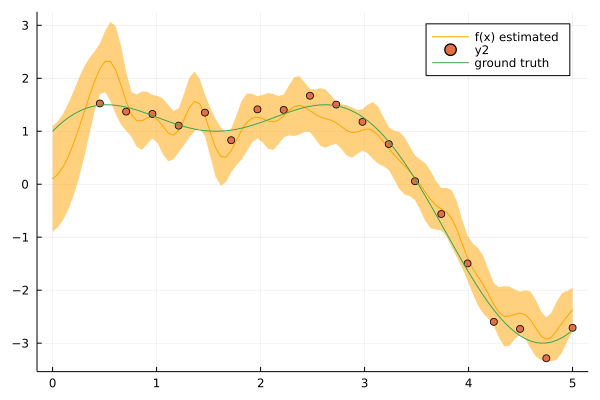

In [12]:
plot(X, meanfunc, ribbon = sqrt.(variance),label="f(x) estimated", c= :orange)
scatter!(x_obser, y_obser)
plot!(x_input, f_true, label="ground truth")

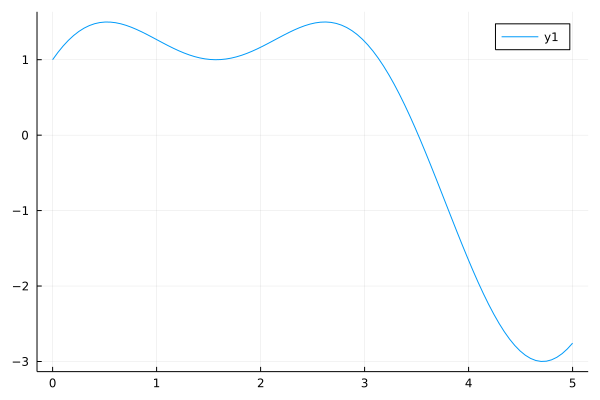

In [13]:
plot(x_input,f_true)